# Setup

### Import cac thu vien can thiet

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary
from tqdm import tqdm

### Set device gpu

In [2]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Config

In [3]:
train_dir="archive/dataset/train"
valid_dir="archive/dataset/valid"
test_dir="archive/dataset/test"

### Sumarry data

In [4]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(train_dir)

There are 2 directories and 0 images in 'archive/dataset/train'.
There are 0 directories and 197826 images in 'archive/dataset/train/real'.
There are 0 directories and 155000 images in 'archive/dataset/train/fake'.


In [6]:
walk_through_dir(valid_dir)

There are 2 directories and 0 images in 'archive/dataset/valid'.
There are 0 directories and 44258 images in 'archive/dataset/valid/real'.
There are 0 directories and 32500 images in 'archive/dataset/valid/fake'.


In [7]:
walk_through_dir(test_dir)

There are 2 directories and 0 images in 'archive/dataset/test'.
There are 0 directories and 44213 images in 'archive/dataset/test/real'.
There are 0 directories and 32500 images in 'archive/dataset/test/fake'.


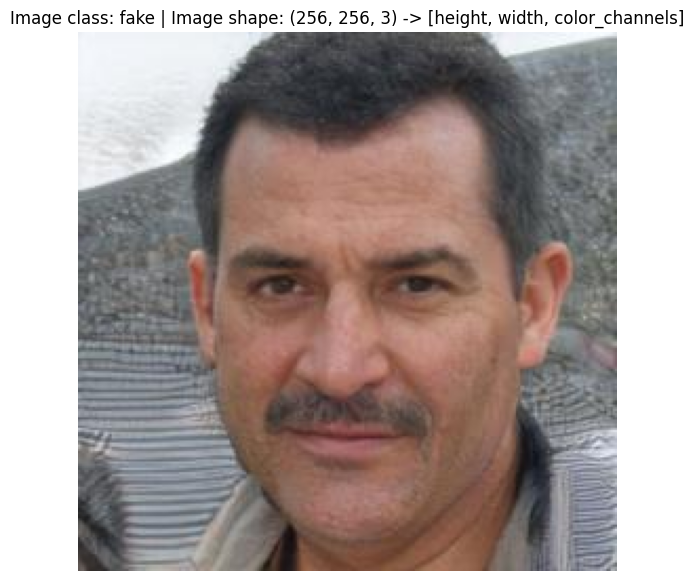

In [8]:
import os
from pathlib import Path

# Define the train directory as a Path object
data_dir = Path(train_dir)

import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

import random

# Get all image paths
image_path_list = list(data_dir.glob("**/*.jpg"))
# Get a random index
random_index = random.randint(0, len(image_path_list) - 1)
# Get the image at the random index
random_image_path = image_path_list[random_index]

# 4. Open image
img = Image.open(random_image_path)

import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)
image_class = random_image_path.parent.stem

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);


### Train, Test Function

In [9]:
def load_checkpoint(checkpoint_path, model, optimizer):
    """
    Load model and optimizer state from a checkpoint.

    Args:
        checkpoint_path (str): Path to the checkpoint file.
        model (torch.nn.Module): The model to load the state into.
        optimizer (torch.optim.Optimizer): The optimizer to load the state into.

    Returns:
        model (torch.nn.Module): The model with loaded state.
        optimizer (torch.optim.Optimizer): The optimizer with loaded state.
        epoch (int): The epoch at which the checkpoint was saved.
    """
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch

In [10]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for (X, y) in tqdm(dataloader, desc="Batch"):
        # Send data to target device
        # print("\rbatch: " + str(batch) + "/" + str(round(int(100000/64))), end = "")
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [11]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [12]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          checkpoint_model_name: str = "",
          epochs: int = 5):
    # 1. Take in various parameters required for training and test steps

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        print("Epoch:",epoch + 1)
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # 6. Save Checkpoints
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'test_loss': test_loss,
            'test_acc': test_acc
        }
        torch.save(checkpoint, f"checkpoints/{checkpoint_model_name}_epoch_{epoch+1}.pth")
        
    # 7. Return the filled results at the end of the epochs
    return results

# EfficientNetV2-S

### Config

In [13]:
BATCH_SIZE = 32

TRAINABLE_EXTRACTOR = False
TRAINABLE_CLASSIFIER = True

NUM_EPOCHS = 10

### Data Loader

In [14]:
from torchvision import datasets

weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
auto_transforms = weights.transforms()

train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=auto_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(valid_dir,
                                 transform=auto_transforms)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 352826
    Root location: archive/dataset/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[384]
               resize_size=[384]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 76758
    Root location: archive/dataset/valid
    StandardTransform
Transform: ImageClassification(
               crop_size=[384]
               resize_size=[384]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )


In [15]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

### Init model

In [16]:
import torch
from torch import nn

def init_model_efficientnet_v2_s(trainable = False):
    """
    Create an EfficientNetV2-S model.

    Returns:
        model (torch.nn.Module): EfficientNetV2-S model.
    """
    weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
    model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)
    
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = trainable
    
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    
    # Recreate the classifier layer and seed it to the target device
    
    return model

# Example usage:
model_efficientnetv2_s = init_model_efficientnet_v2_s(TRAINABLE_EXTRACTOR)


In [17]:
summary(model_efficientnetv2_s,
       input_size=(BATCH_SIZE, 3, 224, 224),
       verbose=0,
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   False
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 24, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 24, 112, 112]   (648)                False
│    │    └─BatchNorm2d (1)                                  [32, 24, 112, 112]   [32, 24, 112, 112]   (48)                 False
│    │    └─SiLU (2)                                         [32, 24, 112, 112]   [32, 24, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 24, 112, 112]   [32, 24

In [18]:
model_efficientnetv2_s.classifier= nn.Sequential(
    torch.nn.Linear(1280,1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000,500),
    torch.nn.Dropout(),
    torch.nn.Linear(in_features=500,
                    out_features=2,
                    bias=True)
    ).to(device)

In [19]:
summary(model_efficientnetv2_s,
       input_size=(BATCH_SIZE, 3, 224, 224),
       verbose=0,
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 24, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 24, 112, 112]   (648)                False
│    │    └─BatchNorm2d (1)                                  [32, 24, 112, 112]   [32, 24, 112, 112]   (48)                 False
│    │    └─SiLU (2)                                         [32, 24, 112, 112]   [32, 24, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 24, 112, 112]   [32, 

### Training

In [21]:
from timeit import default_timer as timer
start_time = timer()

torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_efficientnetv2_s.parameters(), lr=0.001)

results = train(model=model_efficientnetv2_s,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        checkpoint_model_name="EfficientNetV2_S",
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Epoch: 1


Batch: 100%|██████████| 11026/11026 [1:45:36<00:00,  1.74it/s]


Epoch: 1 | train_loss: 0.1684 | train_acc: 0.9322 | test_loss: 0.1166 | test_acc: 0.9574
Epoch: 2


Batch: 100%|██████████| 11026/11026 [1:49:24<00:00,  1.68it/s] 


Epoch: 2 | train_loss: 0.1361 | train_acc: 0.9480 | test_loss: 0.1383 | test_acc: 0.9493
Epoch: 3


Batch:  22%|██▏       | 2434/11026 [23:11<1:21:52,  1.75it/s]


KeyboardInterrupt: 